# Statistics

In [ ]:
%load_ext autoreload
%autoreload 2

## Graph statistics

In [ ]:
import graph_helper
import dataset_helper
import matplotlib.pyplot as plt
from IPython.display import display

for graph_cache_file in dataset_helper.get_all_cached_graph_datasets():
    if 'ana' in graph_cache_file: continue
    if 'gml' not in graph_cache_file: continue
    cache_filename = graph_cache_file.split('/')[-1]
    print('{} {}'.format('#' * 20, cache_filename))
    X, Y = dataset_helper.get_dataset_cached(graph_cache_file)
    num_classes = min(len(set(X)), 20)
    #dataset_helper.plot_dataset_class_distribution(X, Y, title = graph_cache_file, figsize=(12, num_classes * 0.8))
    df = graph_helper.get_graph_stats(X, Y)
    
    ax = df['num_graphs'].plot.barh(title = 'Graphs per topic\n(Dataset: {})'.format(cache_filename.replace('.npy', '')), legend = True, figsize = (14, 8))
    ax.set_xlabel('# graphs')
    display(df)
    plt.show()
    break

In [ ]:
from glob import glob 
import pickle
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

df_all = None
for result_file in glob('data/results/*.npy'):
    with open(result_file, 'rb') as f:
        result = pickle.load(f)
    dataset = result_file.split('/')[-1].rsplit('.', 4)[0]
    is_graph_dataset = 'graph' in dataset
    is_cooccurrence_dataset = 'cooccurrence' in dataset
    dataset_name = dataset
    if is_graph_dataset:
        result['wl_iteration'] = int(dataset.split('.')[-1])
        parts = dataset.split('_')
        if is_cooccurrence_dataset:
            dataset_name = parts[-1].split('_')[0].split('.')[0]
            result['words'] = parts[4]
            result['window_size'] = parts[3]
        # GML
        else:
            #result['window_size'] = -1
            dataset_name = parts[3].split('.')[0]
        result['graph_type'] = 'cooccurrence' if is_cooccurrence_dataset else 'concept-graph'
        result['set_type'] = 'graph'
    else:
        result['set_type'] = 'text'
        dataset_name = dataset.split('_')[1]
    for param in result['params']:
        del param['clf']
    if dataset_name.endswith('-single'):
        dataset_name = dataset_name.rsplit('-', 1)[0]
    del result['param_clf']
    result['dataset'] = dataset_name
    result_df = pd.DataFrame(result).sort_values(by = 'dataset', ascending = False)
    
    if df_all is None:
        df_all = result_df
    else:
        df_all = df_all.append(result_df)

        


df_graphs = df_all[df_all.set_type == 'graph']
df_texts = df_all[df_all.set_type == 'text']
df_graphs['window_size'].fillna('concept-graph', inplace = True)
df_graphs['wl_iteration'] = df_graphs.wl_iteration.astype(int)

/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


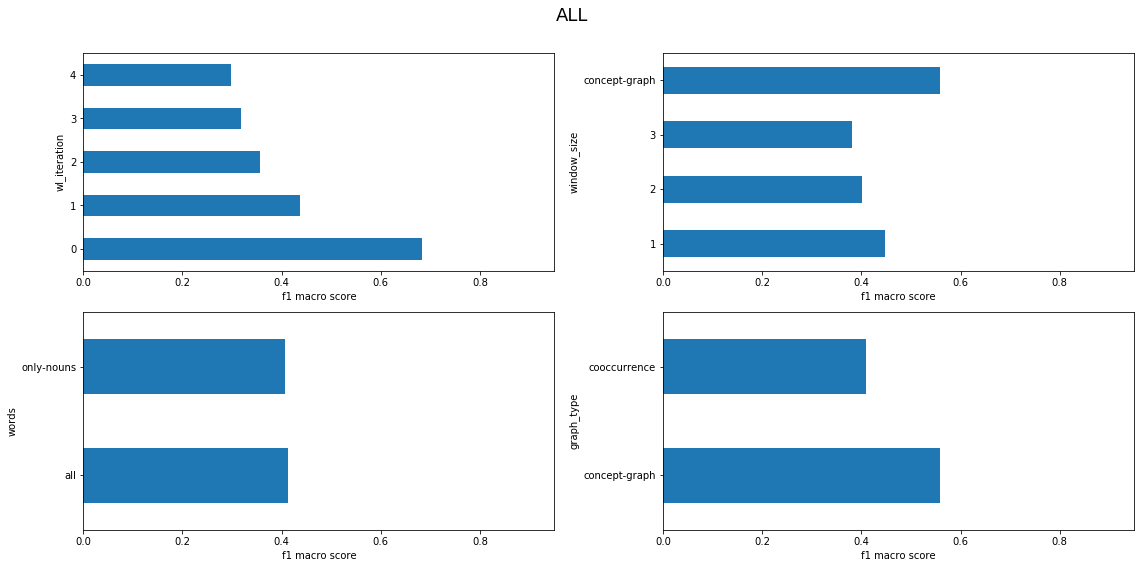

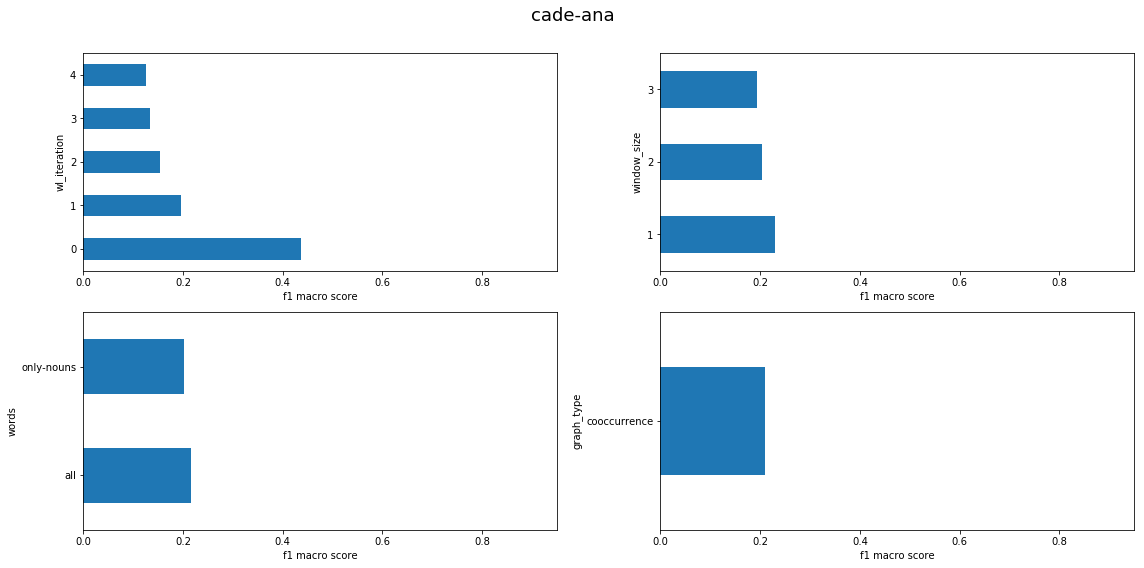

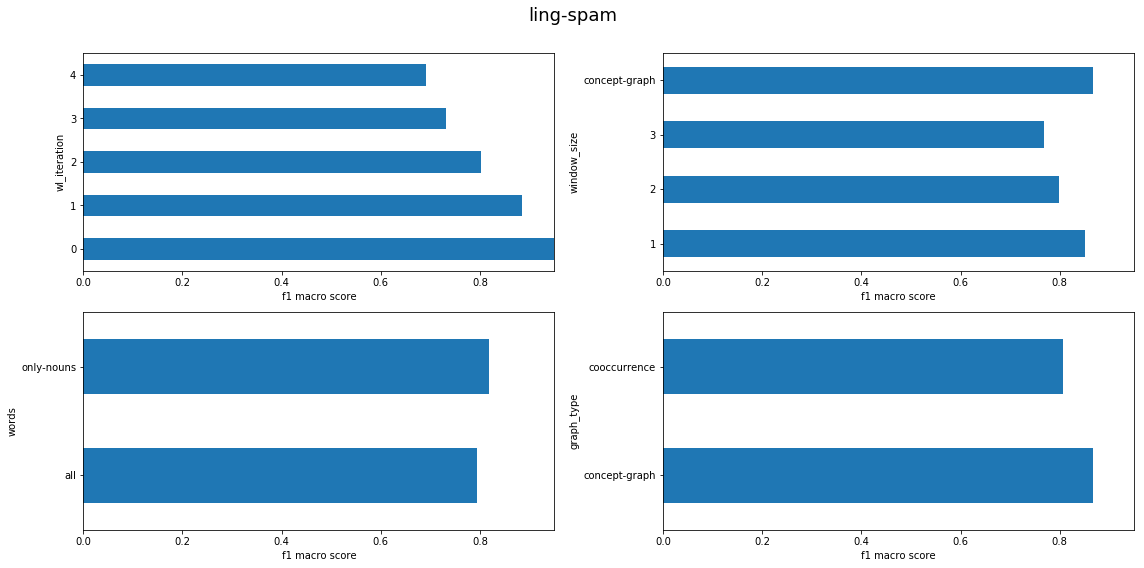

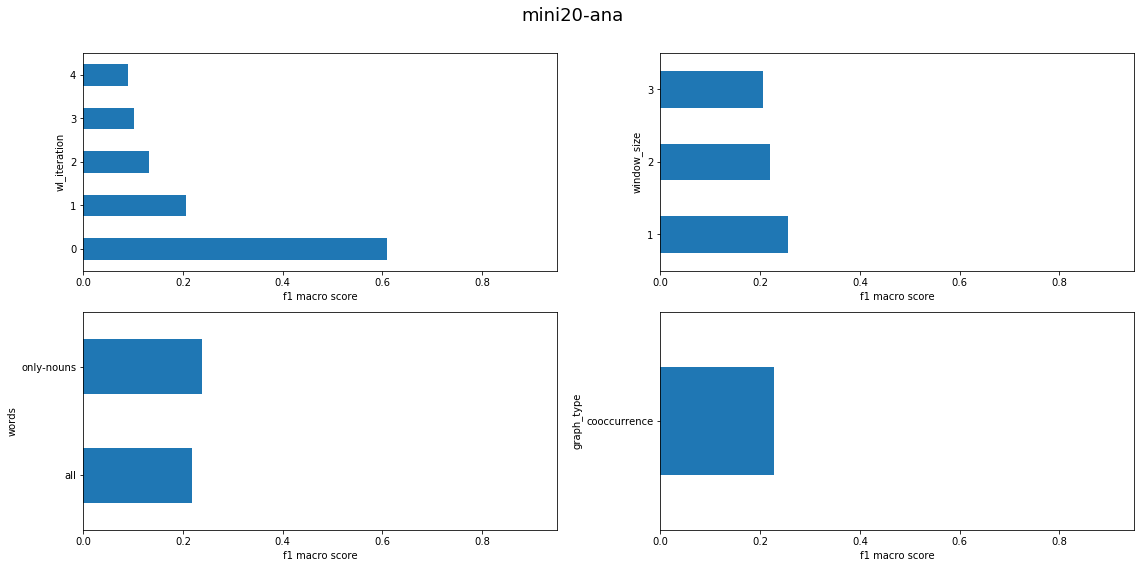

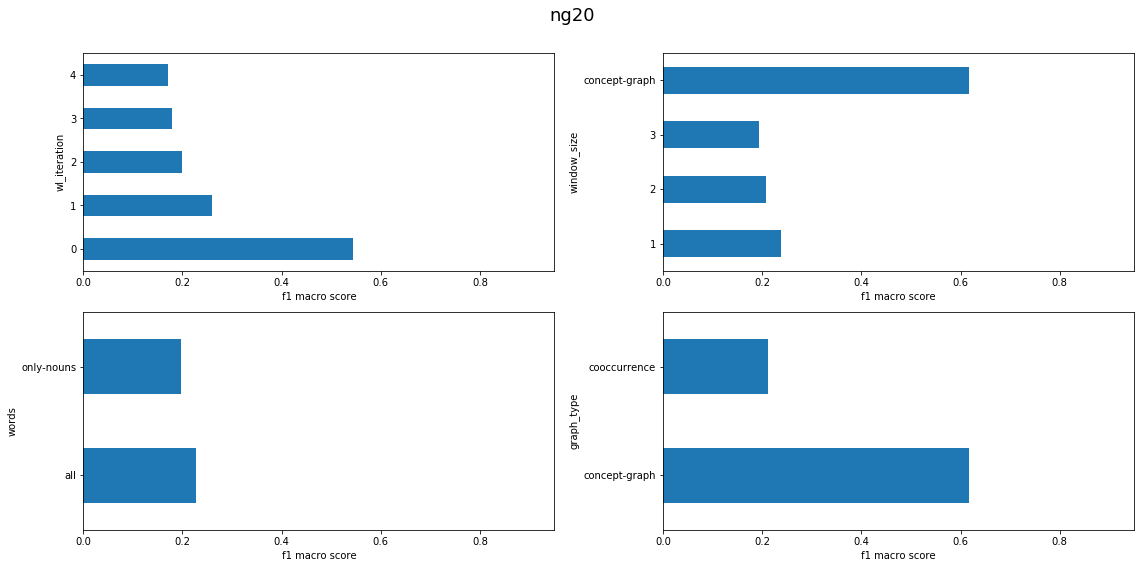

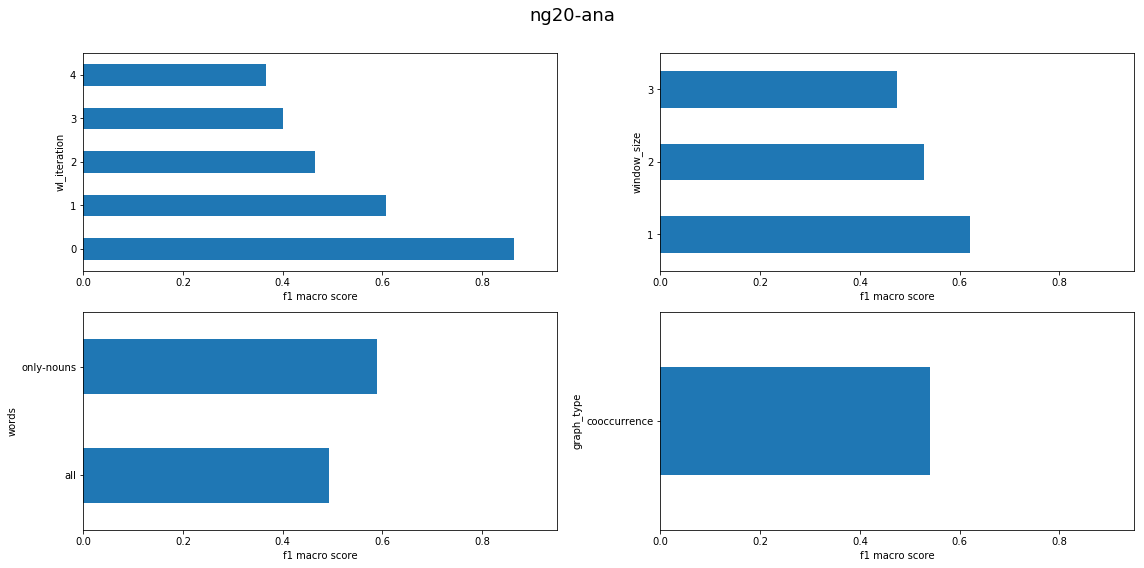

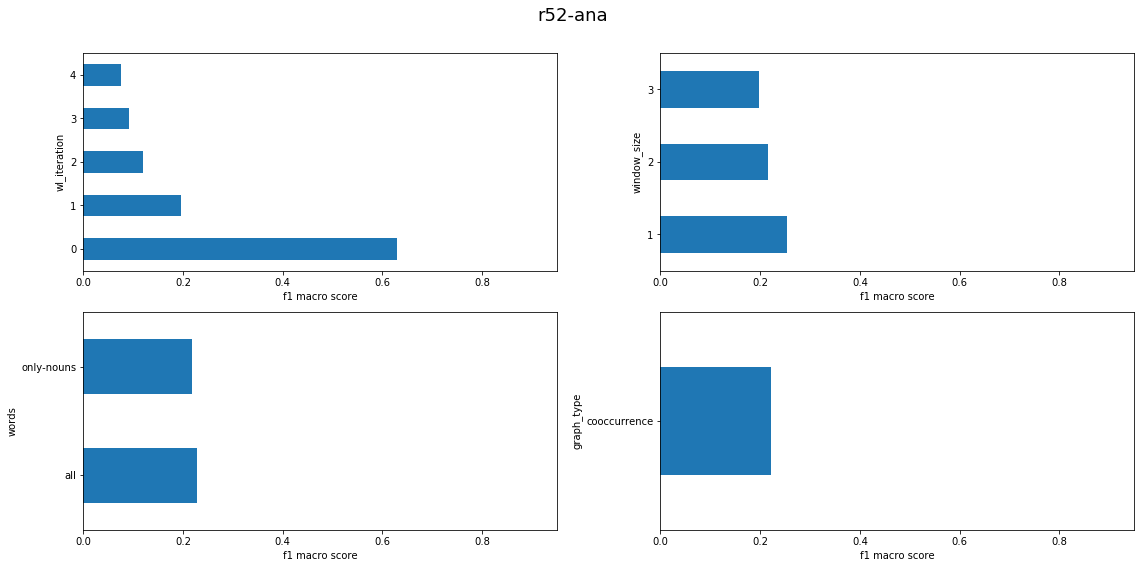

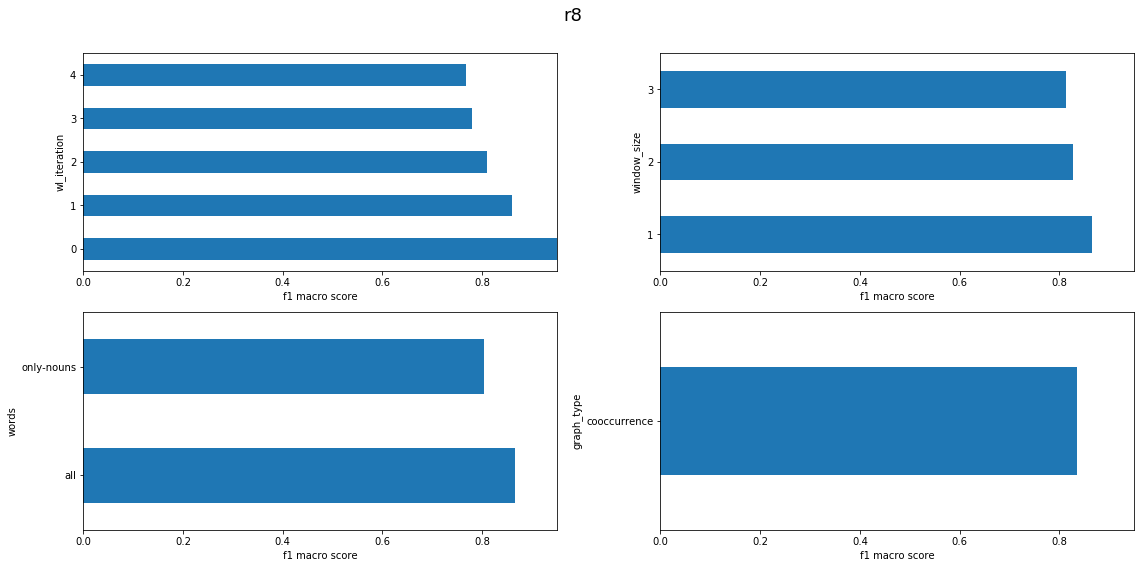

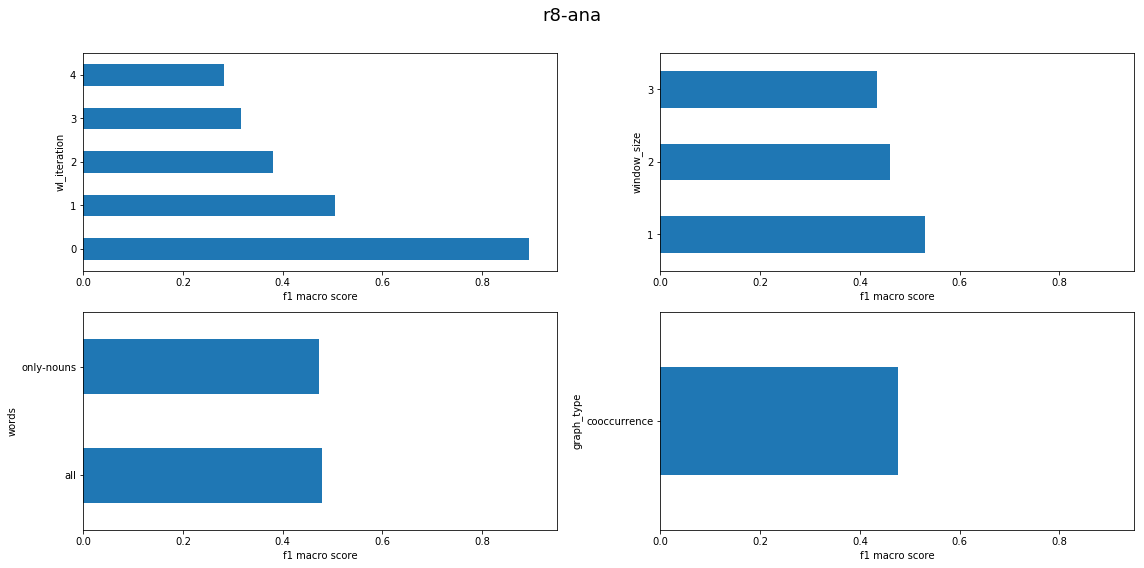

In [ ]:
def plot_distributions(df, title = None):
    fig, axes_indexed = plt.subplots(nrows = 2, ncols=2, figsize = (16, 8))

    axes = []
    for ax_row in axes_indexed:
        axes += list(ax_row)

    for val, ax in zip(['wl_iteration', 'window_size', 'words', 'graph_type'], axes):
        df.groupby(val).mean_test_score.mean().plot(kind = 'barh', ax = ax, xlim = (0, 0.95))
        ax.set_xlabel('f1 macro score')
    plt.suptitle(title, size = 18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)

plot_distributions(df_graphs, title = 'ALL')
plt.show()
for name, df_graph_dataset in df_graphs.groupby('dataset'):
    plot_distributions(df_graph_dataset, title = name)
    plt.show()

In [ ]:
import json

with open('data/check-w2v-results.json') as f:
    w2v_results = json.load(f)
 
per_embedding_type = {}
for dataset, value in w2v_results.items():
    print(dataset)
    for embedding_raw, cache_files in sorted(value.items(), key = lambda x: x[0]):
        embedding = embedding_raw.split('/')[-1].rsplit('.', 2)[0]
        if len(cache_files.keys()) != 2: continue
        print('\t{}'.format(embedding))
        if embedding not in per_embedding_type:
            per_embedding_type[embedding] = {}
        per_embedding_type[embedding][dataset] = []
        for dataset_file, counts in sorted(cache_files.items(), key = lambda x: x[0]):
            not_found_ratio = int(counts['counts']['not_found'] / counts['num_labels'] * 100)
            is_gml = 'dataset_graph_gml' in dataset_file
            per_embedding_type[embedding][dataset].append((is_gml, not_found_ratio))
            print('\t\t{:4} missing  {:3>}%'.format('gml' if is_gml else 'co', not_found_ratio))
        per_embedding_type[embedding][dataset] = per_embedding_type[embedding][dataset][1][1]  #sum(y for x, y in per_embedding_type[embedding][dataset]) / 2
df = pd.DataFrame(per_embedding_type)
df.mean()# .mean() #.mean().to_frame()